# Preparating the project

In [18]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, Sequential
import keras_tuner as kt

import gc
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [19]:
# functions used in this project

def extract_values_from_history(history):
  train_accuracy = history.history['accuracy']
  validation_accuracy = history.history['val_accuracy']

  train_loss = history.history['loss']
  validation_loss = history.history['val_loss']

  return train_accuracy, validation_accuracy, train_loss, validation_loss

def accuracy_and_loss_graph(train_accuracy, validation_accuracy, train_loss, validation_loss):
  # Accuracy and Loss graphical representation
  plt.figure(figsize=(8, 8))

  plt.subplot(2, 1, 1)
  plt.plot(train_accuracy, label='Training Accuracy')
  plt.plot(validation_accuracy, label='Validation Accuracy')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(train_loss, label='Training Loss')
  plt.plot(validation_loss, label='Validation Loss')
  plt.ylabel('Cross Entropy')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

def mean_metrics(history):
  mean_accuracy = round(np.mean(history.history["accuracy"]) * 100, 2)
  std_accuracy = round(np.std(history.history["accuracy"]) * 100, 2)
  mean_validation_accuracy = round(np.mean(history.history["val_accuracy"]) * 100, 2)
  std_validation_accuracy = round(np.std(history.history["val_accuracy"]) * 100, 2)

  mean_loss = round(np.mean(history.history["loss"]), 3)
  std_loss = round(np.std(history.history["loss"]), 3)
  mean_validation_loss = round(np.mean(history.history["loss"]), 3)
  std_validation_loss = round(np.std(history.history["loss"]), 3)

  print(f"Mean Accuracy: {mean_accuracy} +/- {std_accuracy} & Mean Validation Accuracy: {mean_validation_accuracy} +/- {std_validation_accuracy}")
  print(f"Mean Loss: {mean_loss} +/- {std_loss} & Mean Validation Loss: {mean_validation_loss} +/- {std_validation_loss}") 

def make_model(model, learning_rate, droprate, size_inner):

    base_model = model(
    weights='imagenet',
    include_top = False,
    input_shape=(224, 224, 3)
    )

    base_model.trainable = False

    #####################################################

    inputs = keras.Input(shape=(224, 224, 3))
    base = base_model(inputs, training=False)

    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation="relu")(vectors)

    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(20, activation="softmax")(drop)
    model = keras.Model(inputs, outputs)

    #####################################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.sparse_categorical_crossentropy

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

def return_best_hps(tuner, train_set, callbacks):
    tuner.search(train_set, epochs=50, callbacks=[callbacks])
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

    return best_hps

def print_hyperparameter(best_hps):
    print(f"""
      The hyperparameter search is complete.\n
      - Optimal learning rate: {best_hps.get('learning_rate')},\n
      - Optimal number of layers: {best_hps.get('size_inner')},\n
      - Optimal dropout: {best_hps.get("dropout")}.
      """)

In [20]:
# create constant used in all project

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
CHANNEL = 3
NUM_CLASSES = 20
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Reading a random picture

In [21]:
path = "data/"

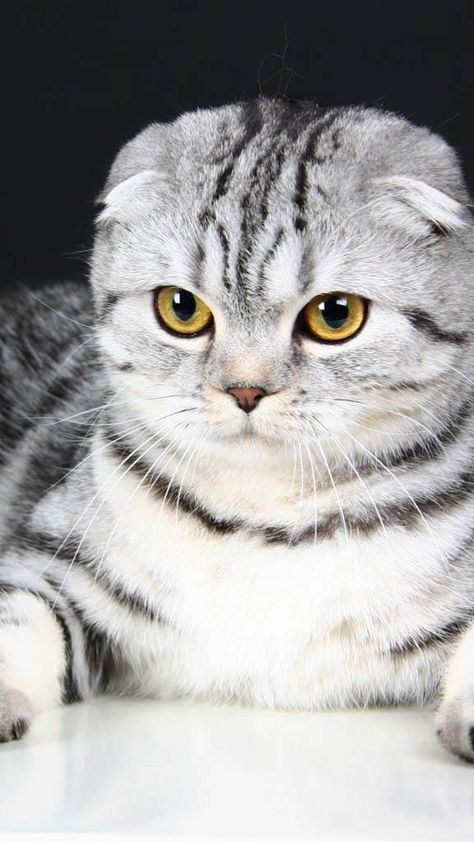

In [22]:
name = "Scottish Fold/Scottish Fold_1.jpg"
fullname = f'{path}/{name}'

# print a kitty picture
load_img(fullname)

# Modelisation

## Preparing the data

In [23]:
img_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Creating a train set
train_set = img_gen.flow_from_directory(
    path,
    subset="training",
    seed=42,
    class_mode="sparse",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

# Creating a validation set
val_set = img_gen.flow_from_directory(
    path,
    subset="validation",
    seed=42,
    class_mode="sparse",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

Found 5600 images belonging to 20 classes.
Found 1400 images belonging to 20 classes.


In [24]:
print(f"Number of classes : {train_set.num_classes}")

Number of classes : 20


In [25]:
print(train_set.class_indices)

{'Abyssinian': 0, 'American Bobtail': 1, 'American Curl': 2, 'American Shorthair': 3, 'Bengal': 4, 'Birman': 5, 'Bombay': 6, 'British Shorthair': 7, 'Egyptian Mau': 8, 'Exotic Shorthair': 9, 'Maine Coon': 10, 'Manx': 11, 'Norwegian Forest': 12, 'Persian': 13, 'Ragdoll': 14, 'Russian Blue': 15, 'Scottish Fold': 16, 'Siamese': 17, 'Sphynx': 18, 'Turkish Angora': 19}


## Xception

### Training model

In [26]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

In [27]:
img_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                             validation_split=0.2)

train_set = img_gen.flow_from_directory(
    path,
    subset="training",
    seed=42,
    class_mode='sparse',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_set = img_gen.flow_from_directory(
    path,
    subset="validation",
    seed=42,
    class_mode='sparse',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 5600 images belonging to 20 classes.
Found 1400 images belonging to 20 classes.


In [28]:
base_model = Xception(weights="imagenet",
                      include_top=False,
                      input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNEL))

base_model.trainable = False

inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNEL))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(vectors)

model = keras.Model(inputs, outputs)

In [29]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.sparse_categorical_crossentropy

In [30]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [31]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 20)                40980     
                                                                 
Total params: 20,902,460
Trainable params: 40,980
Non-trainable params: 20,861,480
_________________________________________________________________


In [33]:
history = model.fit(train_set,
                    epochs=10,
                    validation_data=val_set)

Epoch 1/10
175/175 [==============================] - 48s 271ms/step - loss: 1.0309 - accuracy: 0.6932 - val_loss: 1.5527 - val_accuracy: 0.6007
Epoch 2/10
175/175 [==============================] - 47s 270ms/step - loss: 0.7756 - accuracy: 0.7538 - val_loss: 1.6871 - val_accuracy: 0.5821
Epoch 3/10
175/175 [==============================] - 47s 270ms/step - loss: 0.6961 - accuracy: 0.7786 - val_loss: 1.6692 - val_accuracy: 0.6229
Epoch 4/10
175/175 [==============================] - 47s 266ms/step - loss: 0.5181 - accuracy: 0.8259 - val_loss: 1.7401 - val_accuracy: 0.6150
Epoch 5/10
175/175 [==============================] - 47s 271ms/step - loss: 0.4649 - accuracy: 0.8454 - val_loss: 1.7742 - val_accuracy: 0.6157
Epoch 6/10
175/175 [==============================] - 47s 269ms/step - loss: 0.3825 - accuracy: 0.8698 - val_loss: 1.7211 - val_accuracy: 0.6364
Epoch 7/10
175/175 [==============================] - 48s 271ms/step - loss: 0.3140 - accuracy: 0.8946 - val_loss: 1.8684 - val_ac

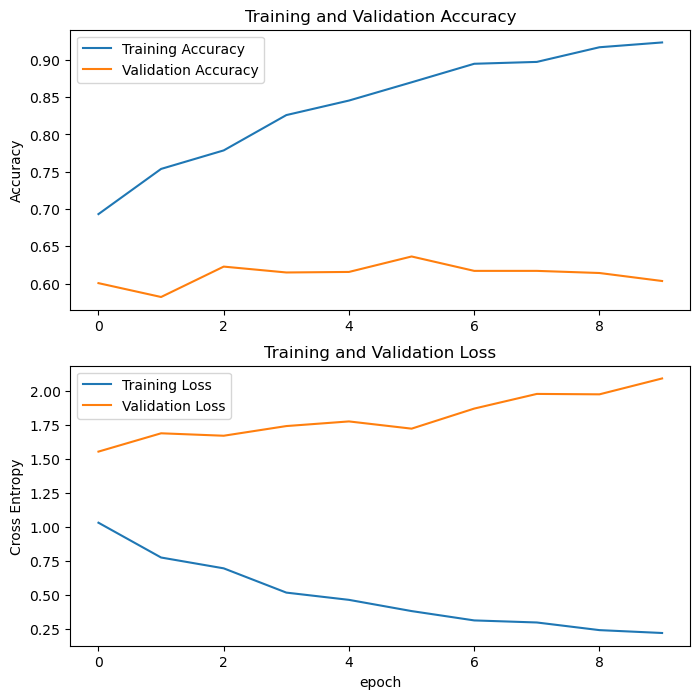

In [34]:
train_accuracy, validation_accuracy, train_loss, validation_loss = extract_values_from_history(history)
accuracy_and_loss_graph(train_accuracy, validation_accuracy, train_loss, validation_loss)

In [35]:
mean_metrics(history)

Mean Accuracy: 83.98 +/- 7.28 & Mean Validation Accuracy: 61.25 +/- 1.37
Mean Loss: 0.495 +/- 0.251 & Mean Validation Loss: 0.495 +/- 0.251


#### Hyperparameters Tuning

In [36]:
def model_builder(hp):

    base_model = Xception(
    weights='imagenet',
    include_top = False,
    input_shape=(224, 224, 3)
    )

    base_model.trainable = False

    #####################################################

    inputs = keras.Input(shape=(224, 224, 3))
    base = base_model(inputs, training=False)

    vectors = keras.layers.GlobalAveragePooling2D()(base)

    size_inner = hp.Choice("size_inner", values=[10, 100, 1000])
    inner = keras.layers.Dense(size_inner, activation="relu")(vectors)

    droprate = hp.Choice('dropout', values = [0.0, 0.2, 0.5, 0.8])
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(20, activation="softmax")(drop)
    model = keras.Model(inputs, outputs)

    #####################################################

    hp_learning_rate = hp.Choice('learning_rate', values=[0.0001, 0.001, 0.01, 0.1])
    optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    loss = keras.losses.sparse_categorical_crossentropy

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [37]:
tuner = kt.Hyperband(model_builder,
                     objective='accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='kt_for_cats_classification',
                     project_name='xception')

In [38]:
best_hps = return_best_hps(tuner, train_set, stop_early)
print_hyperparameter(best_hps)

Trial 30 Complete [00h 06m 34s]
accuracy: 0.6798214316368103

Best accuracy So Far: 0.9049999713897705
Total elapsed time: 01h 20m 02s

      The hyperparameter search is complete.

      - Optimal learning rate: 0.001,

      - Optimal number of layers: 100,

      - Optimal dropout: 0.0.
      


In [40]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_set, epochs=50, validation_data=val_set)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
175/175 [==============================] - 51s 277ms/step - loss: 1.4664 - accuracy: 0.5407 - val_loss: 1.2507 - val_accuracy: 0.5907
Epoch 2/50
175/175 [==============================] - 48s 273ms/step - loss: 0.9697 - accuracy: 0.6891 - val_loss: 1.1277 - val_accuracy: 0.6243
Epoch 3/50
175/175 [==============================] - 47s 271ms/step - loss: 0.8099 - accuracy: 0.7402 - val_loss: 1.1158 - val_accuracy: 0.6271
Epoch 4/50
175/175 [==============================] - 47s 270ms/step - loss: 0.6996 - accuracy: 0.7732 - val_loss: 1.1140 - val_accuracy: 0.6371
Epoch 5/50
175/175 [==============================] - 47s 270ms/step - loss: 0.6196 - accuracy: 0.7971 - val_loss: 1.0827 - val_accuracy: 0.6507
Epoch 6/50
175/175 [==============================] - 47s 270ms/step - loss: 0.5427 - accuracy: 0.8275 - val_loss: 1.0507 - val_accuracy: 0.6557
Epoch 7/50
175/175 [==============================] - 48s 271ms/step - loss: 0.4867 - accuracy: 0.8416 - val_loss: 1.0782 - val_ac

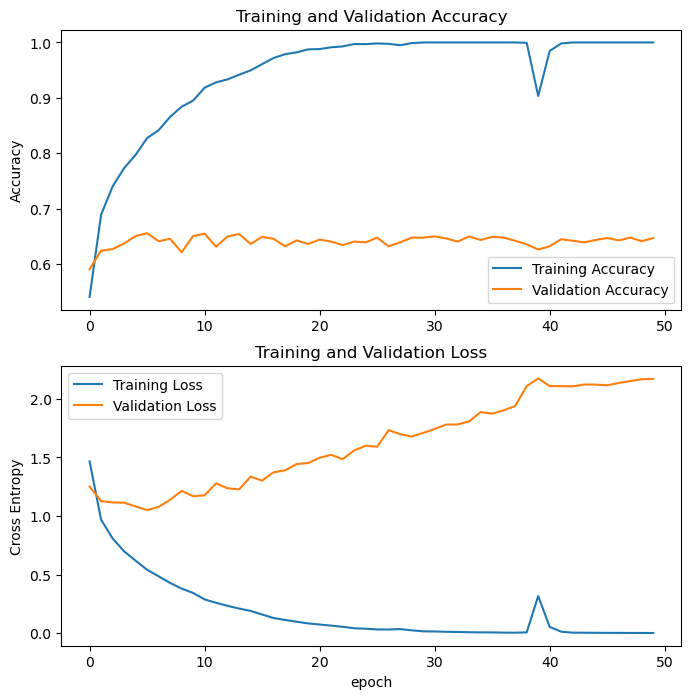

In [41]:
train_accuracy, validation_accuracy, train_loss, validation_loss = extract_values_from_history(history)
accuracy_and_loss_graph(train_accuracy, validation_accuracy, train_loss, validation_loss)

In [42]:
mean_metrics(history)

Mean Accuracy: 94.5 +/- 9.48 & Mean Validation Accuracy: 64.11 +/- 1.06
Mean Loss: 0.189 +/- 0.293 & Mean Validation Loss: 0.189 +/- 0.293


In [43]:
del history
del model
del train_set
del val_set
del tuner
del best_hps
del preprocess_input
gc.collect()

23347

## ResNet50

### Training model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
img_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                             validation_split=0.2)

train_set = img_gen.flow_from_directory(
    path,
    subset="training",
    seed=42,
    class_mode='sparse',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_set = img_gen.flow_from_directory(
    path,
    subset="validation",
    seed=42,
    class_mode='sparse',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

In [ ]:
base_model = ResNet50(weights="imagenet",
                            include_top=False,
                            input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNEL))

base_model.trainable = False

inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH,CHANNEL))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(vectors)

model = keras.Model(inputs, outputs)

learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.sparse_categorical_crossentropy

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(train_set,
                    epochs=30,
                    validation_data=val_set)

In [ ]:
train_accuracy, validation_accuracy, train_loss, validation_loss = extract_values_from_history(history)
accuracy_and_loss_graph(train_accuracy, validation_accuracy, train_loss, validation_loss)

In [ ]:
mean_metrics(history)

### Hyperparameters Tuning

In [ ]:
def model_builder(hp):

    base_model = ResNet50(
    weights='imagenet',
    include_top = False,
    input_shape=(224, 224, 3)
    )

    base_model.trainable = False

    #####################################################

    inputs = keras.Input(shape=(224, 224, 3))
    base = base_model(inputs, training=False)

    vectors = keras.layers.GlobalAveragePooling2D()(base)

    size_inner = hp.Choice("size_inner", values=[10, 100, 1000])
    inner = keras.layers.Dense(size_inner, activation="relu")(vectors)

    droprate = hp.Choice('dropout', values = [0.0, 0.2, 0.5, 0.8])
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(20, activation="softmax")(drop)
    model = keras.Model(inputs, outputs)

    #####################################################

    hp_learning_rate = hp.Choice('learning_rate', values=[0.0001, 0.001, 0.01, 0.1])
    optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    loss = keras.losses.sparse_categorical_crossentropy

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='kt_for_cats_classification',
                     project_name='resNet50')

In [ ]:
best_hps = return_best_hps(tuner, train_set, stop_early)
print_hyperparameter(best_hps)

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_set, epochs=50, validation_data=val_set)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
train_accuracy, validation_accuracy, train_loss, validation_loss = extract_values_from_history(history)
accuracy_and_loss_graph(train_accuracy, validation_accuracy, train_loss, validation_loss)

In [ ]:
mean_metrics(history)

In [ ]:
del history
del model
del train_set
del val_set
del tuner
del best_hps
del preprocess_input
gc.collect()

## EfficientNet

### Training model

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientBNet7
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
img_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                             validation_split=0.2)

train_set = img_gen.flow_from_directory(
    path,
    subset="training",
    seed=42,
    class_mode='sparse',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_set = img_gen.flow_from_directory(
    path,
    subset="validation",
    seed=42,
    class_mode='sparse',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

In [ ]:
base_model = EfficientBNet7(weights="imagenet",
                            include_top=False,
                            input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNEL))

base_model.trainable = False

inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH,CHANNEL))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(vectors)

model = keras.Model(inputs, outputs)

learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.sparse_categorical_crossentropy

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(train_set,
                    epochs=30,
                    validation_data=val_set)

In [ ]:
train_accuracy, validation_accuracy, train_loss, validation_loss = extract_values_from_history(history)
accuracy_and_loss_graph(train_accuracy, validation_accuracy, train_loss, validation_loss)

In [ ]:
mean_metrics(history)

### Hyperparameters Tuning

In [ ]:
def model_builder(hp):

    base_model = EfficientBNet7(
    weights='imagenet',
    include_top = False,
    input_shape=(224, 224, 3)
    )

    base_model.trainable = False

    #####################################################

    inputs = keras.Input(shape=(224, 224, 3))
    base = base_model(inputs, training=False)

    vectors = keras.layers.GlobalAveragePooling2D()(base)

    size_inner = hp.Choice("size_inner", values=[10, 100, 1000])
    inner = keras.layers.Dense(size_inner, activation="relu")(vectors)

    droprate = hp.Choice('dropout', values = [0.0, 0.2, 0.5, 0.8])
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(20, activation="softmax")(drop)
    model = keras.Model(inputs, outputs)

    #####################################################

    hp_learning_rate = hp.Choice('learning_rate', values=[0.0001, 0.001, 0.01, 0.1])
    optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    loss = keras.losses.sparse_categorical_crossentropy

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='kt_for_cats_classification',
                     project_name='efficientBNet7')

In [ ]:
best_hps = return_best_hps(tuner, train_set, stop_early)
print_hyperparameter(best_hps)

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_set, epochs=50, validation_data=val_set)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
train_accuracy, validation_accuracy, train_loss, validation_loss = extract_values_from_history(history)
accuracy_and_loss_graph(train_accuracy, validation_accuracy, train_loss, validation_loss)

In [ ]:
mean_metrics(history)

In [ ]:
del history
del model
del train_set
del val_set
del tuner
del best_hps
del preprocess_input
gc.collect()

# Training the best model

In [ ]:
from tensorflow.keras.applications. import preprocess_input
from tensorflow.keras.applications. import

## Data Augmentation

In [ ]:
train_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 50,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    validation_split=0.2,
    fill_mode = "nearest"
)

train_set = train_gen.flow_from_directory(
    path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

val_set = val_gen.flow_from_directory(
    path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    BATCH_SIZE=32,
    shuffle=BATCH_SIZE
)

## Prepare checkpointing

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'model_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

## Training the model

In [ ]:
model = make_model(
    model =
    input_size = ,
    learning_rate=,
    size_inner=,
    droprate=)
history = model.fit(train_set, epochs=, validation_data=val_set,
                   callbacks=[checkpoint])

## Save the model as h5 file